In [2]:
from DataPreprocessing.python.Data import *

import pandas as pd
import numpy as np


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In [7]:
rootData = Data("/Users/czkaiweb/Research/ErdosBootCamp/Project/ProjectData/Root_Insurance_data.csv")
rootData.loadData()
rootData.factorizeData()
rootData.splitData(fraction=[0.5,0.3,0.2],random_seed=42)
data_train = rootData.getTrainDataCopy()
data_validation = rootData.getValidationDataCopy()
data_test  = rootData.getTestDataCopy()

X_train = data_train.iloc[:, 0:4].values
y_train = data_train.iloc[:, -1].values

X_validation = data_validation.iloc[:, 0:4].values
y_validation = data_validation.iloc[:, -1].values

X_test = data_test.iloc[:, 0:4].values
y_test = data_test.iloc[:, -1].values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

model = MLPClassifier(hidden_layer_sizes=30, 
                    activation='relu',solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True)


parameters = {'activation':['relu','tanh'],
              'learning_rate_init': [0.01, 0.02, .04, .08, 0.1, 0.2, 0.4], #so called `eta` value
              'solver': ['adam','sgd']}

clf = GridSearchCV(model, parameters, n_jobs=5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)


In [58]:
clf.fit(X_train, y_train)
y_vpred = clf.predict(X_validation)
y_tpred = clf.predict(X_test)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [72]:
print(clf.best_score_)
print(clf.best_params_)

0.7199675000685007
{'activation': 'tanh', 'learning_rate_init': 0.1, 'solver': 'sgd'}


In [73]:
clf.predict(np.array([1.26363794,  1.4545057,  1.9892577 ,  1.04333826]).reshape(1,-1))

array([0])

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [61]:
fpr, tpr, thresholds = roc_curve(y_validation, y_vpred, pos_label=1)

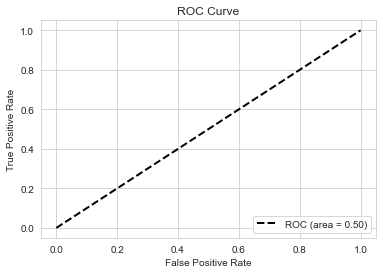

In [62]:
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
def getReward(regressor, threshold, Xs, ys):
    reward = 0
    for index,X in enumerate(Xs):
        if regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 1 :
            reward += 130
        elif regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 0 :
            reward += -10
    return reward
            

In [63]:
reward_buffer = []
print(thresholds)
for threshold in thresholds:
    reward = getReward(clf,threshold,X_validation,y_validation)
    reward_buffer.append(reward)
    
reward_buffer

[1 0]


[0, 0]

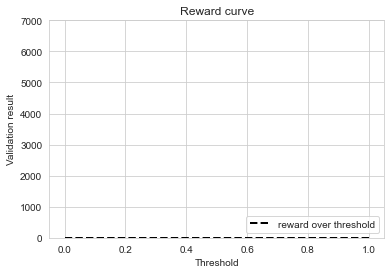

In [79]:
plt.plot(thresholds, reward_buffer, 'k--', label='reward over threshold', lw=2)
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 7000])
plt.xlabel('Threshold')
plt.ylabel('Validation result')
plt.title('Reward curve')
plt.legend(loc="lower right")
plt.show()

In [75]:
i_best_threshold = reward_buffer.index(max(reward_buffer))
best_threshold  = thresholds[i_best_threshold]
print("best_threshold = {}".format(best_threshold))

best_threshold = 1


In [78]:
reward = getReward(clf,best_threshold,X_test,y_test)
print("reward = {}".format(reward))
reward_naive = getReward(clf,-1,X_test,y_test)
print("naive reward = {}".format(reward_naive))

reward = 0
naive reward = 5320
